# Rain Australia

---

**Autores:**

*   Vera, Gonzalo
*   Skrauba, Axel


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from imblearn.combine import SMOTETomek
from collections import Counter

from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

pd.set_option("precision", 3)

\tableofcontents

# Objetivo
Realizar el análisis pertinente sobre el set de datos "weatherAUS.csv"*, de acuerdo al contenido abordado en la materia. Finalmente, decidir si se puede crear algún modelo con estas variables para poder predecir si va a llover al día siguiente.


---



\*Contexto: *Set de datos de variables climáticas en Australia.*


Este conjunto de datos contiene observaciones meteorológicas diarias de numerosas estaciones meteorológicas australianas.
La variable de destino **RainTomorrow** significa: ¿Llovió al día siguiente? *Yes* o *No*.

# Análisis conjunto de datos
Contamos con 24 variables en el dataset. La variable de respuesta en este caso es RainTomorrow y buscamos predecirla mediante las demás predictoras. Excepto RISK_MM ya que provoca data leakage.

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AE/weatherAUS.csv')
df = pd.read_csv('./weatherAUS.csv') #Toqué esto porque no me dejaba acceder al Drive
df.drop(columns = 'RISK_MM', inplace = True)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

\newpage

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

En la tabla anterior, se tiene una descripción resumida de las variables del set de datos. La mayoría son del tipo numéricas (float64) pero existen otras categóricas (object). En principio, se tienen 16 variables numéricas y 7 categóricas. Las categóricas son las que serán analizadas y codificadas para su utilización en los diferentes modelos a abordar.

# Descripción de variables

Las tabla siguiente muestra el significado de cada una de las variables para referencia.

\begin{tabular}{ll}
\toprule
Name             &                          Description \\
\midrule
Date             &           The date of observation (a Date object). \\
Location         &  The common name of the location of the weather... \\
MinTemp          &        The minimum temperature in degrees celsius. \\
MaxTemp          &        The maximum temperature in degrees celsius. \\
Rainfall         &  The amount of rainfall recorded for the day in... \\
Evaporation      &  The so-called Class A pan evaporation (mm) in ... \\
Sunshine         &  The number of hours of bright sunshine in the ... \\
WindGustDir      &  The direction of the strongest wind gust in th... \\
WindGustSpeed    &  The speed (km/h) of the strongest wind gust in... \\
Temp9am          &                    Temperature (degrees C) at 9am. \\
RelHumid9am      &                Relative humidity (percent) at 9am. \\
Cloud9am         &  Fraction of sky obscured by cloud at 9am. This... \\
WindSpeed9am     &  Wind speed (km/hr) averaged over 10 minutes pr... \\
Pressure9am      &  Atmospheric pressure (hpa) reduced to mean sea... \\
Temp3pm          &                    Temperature (degrees C) at 3pm. \\
RelHumid3pm      &                Relative humidity (percent) at 3pm. \\
Cloud3pm         &  Fraction of sky obscured by cloud (in "oktas":... \\
WindSpeed3pm     &  Wind speed (km/hr) averaged over 10 minutes pr... \\
Pressure3pm      &  Atmospheric pressure (hpa) reduced to mean sea... \\
ChangeTemp       &                             Change in temperature. \\
ChangeTempDir    &                Direction of change in temperature. \\
ChangeTempMag    &                Magnitude of change in temperature. \\
ChangeWindDirect &                          Direction of wind change. \\
MaxWindPeriod    &                            Period of maximum wind. \\
RainToday        &  Integer: 1 if precipitation (mm) in the 24 hou... \\
TempRange        &  Difference between minimum and maximum tempera... \\
PressureChange   &                                Change in pressure. \\
RISK\_MM          &  The amount of rain. A kind of measure of the "... \\
RainTomorrow     &          The target variable. Did it rain tomorrow \\
\bottomrule
\end{tabular}

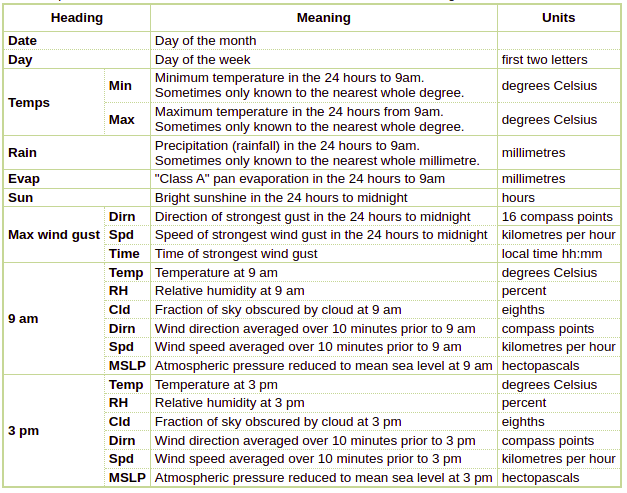

# **Manejo de datos faltantes**

En la tabla siguiente se presentan las variables con datos faltantes, indicando el porcentaje computado de los mismos. La tabla se encuentra ordenada, siendo el primer valor el que carece de un mayor número de valores.

\begin{tabular}{lr}
\toprule
{} &  Porcentaje Nulos \\
\midrule
Sunshine      &         47.692924 \\
Evaporation   &         42.789026 \\
Cloud3pm      &         40.152469 \\
Cloud9am      &         37.735332 \\
Pressure9am   &          9.855619 \\
Pressure3pm   &          9.832411 \\
WindDir9am    &          7.041838 \\
WindGustDir   &          6.561504 \\
WindGustSpeed &          6.519308 \\
WindDir3pm    &          2.656952 \\
\bottomrule
\end{tabular}


La siguiente gráfica, representa lo equivalente a la tabla anterior con el porcentaje de valores faltantes por variables. La gráfica permite una identificación visual rápida, además de permitir detectar algún patrón en lo que respecta a la ausencia de los datos.

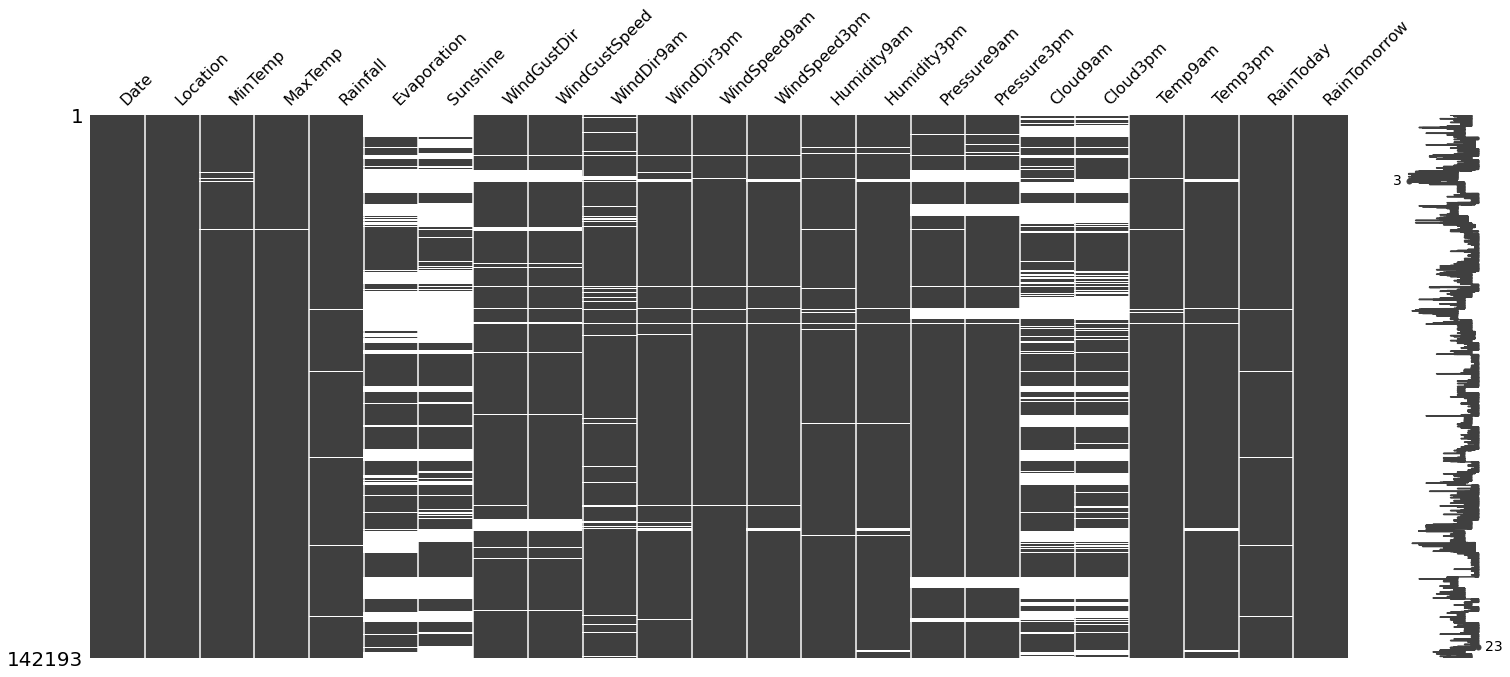

In [ ]:
import missingno
missingno.matrix(df); # Genera la gráfica con los huecos en los datos faltantes. Bastante intuitivo para un análisis visual rápido
# Datos faltantes por columna, de forma porcentual. (Para tener algo cuantitativo que respalde la inspección visual)
# porcentaje de nulos
# pd.DataFrame(df.isnull().mean()*100, index = df.columns, columns = ['Porcentaje Nulos']).sort_values(by = ['Porcentaje Nulos'],ascending=False).head(10).to_latex()

Habría que determinar si el mecanismo de pérdida de datos es completamente aleatorio o no. Las columnas mayormente afectadas son Sunshine (47%), Evaporation (42%), Cloud3pm (40%) y Cloud9am (37%). En las mismas, las pérdidas se agrupan en grandes bloques. Habría que contrastar esto con otras columnas, tal vez exista alguna relación. Por ejemplo, alguna ciudad no podía medir esos parámetros por no contar con los instrumentos. Dado el caso, se podría utilizar alguna técnica para la imputación de los mismos.
En algunas zonas, se percibe que la pérdida de datos se da para una misma fila en casi todas las columnas. Estos podrían descartarse directamente.

# Variable respuesta

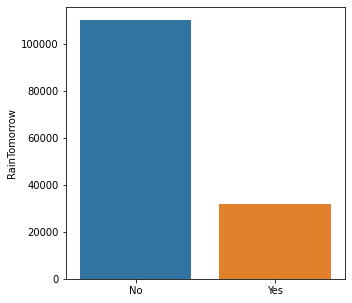

In [ ]:
# el set esta bastante desbalanceado
plt.rcParams['figure.figsize'] = (5,5)
sns.barplot(x = df['RainTomorrow'].unique(), y = df['RainTomorrow'].value_counts());

Como se observa en la figura, la clase se encuentra desbalanceada. Los días que "No" llueven son la mayoría. Para este inconveniente, se podría optar por una gestión de desequilibrio de clases. 

Algunas estrategias posibles son el balanceo del conjunto de datos realizando un sub sampleo de los casos negativos o creando registros positivos ficticios. Otra forma de compensar el efecto del desequilibro es la modificación del threshold en el clasificador, por ejemplo, en regresión logística o discriminantes lineales.


# **Tratamiento de variables**
Las variables predictoras no pueden ser ingresadas en los algoritmos de modelado sin antes ser adecuadas para su uso. Entre otras cosas, se deben codificar las variables categóricas y analizar la correlación simple entre variables numéricas.

## Variables categóricas
* **Date**: Esta variable como se presenta no aporta información al modelo. La predicción de lluvia al día siguiente no se ve afectada por su fecha exacta pero si es interesante la época del año que se está atravezando. Cambiarla a una variable discreta ordinal tampoco tiene sentido porque la distancia entre el mes 12 y el 1 es la misma que entre 4 y 5. Por lo que proponemos cambiar a una variable categórica que indique la estación, o sea; Verano, Otoño, Invierno y Primavera.
* **Location**: Las condiciones climáticas pueden variar de ciudad a ciudad por lo que se incluye en el modelo mediante una codificacion one-hot encoding.
* **WindGustDir, WinDir9am, WinDir3pm**: Son variables categóricas en principio. Indica la dirección del viento en 16 puntos de compás. Como provienen de un círculo completo es posible transformar estos puntos en grados. Según http://www.nciwormshead.org.uk/training/compass/68-compass-rose.
Sin embargo, la distancia no se cumple en la circunferencia completa. Al igual que en la fecha, la distancia entre 359º y 0º es 1º y no es interpretado de esa manera por el modelo. A tales efecto, proponemos dividir cada direccion en dos columnas asociadas a las proyecciones horizontal y vertical mediante el seno y el coseno. Las proyecciones son variables numéricas que guardan una relación de distancia entre las diferentes direcciones.


A continuación, se procesan las variables categóricas de acuerdo al análisis realizado previamente.

### Date
Transformamos esta variable a una categórica que represente la estación del año y la codificamos por one-hot encoding. El resultado de este procedimiento, se percibe en la gráfica y tabla de esta sección.

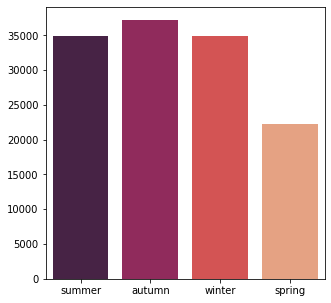

In [ ]:
df['Month'] = pd.to_datetime(df['Date']).dt.month
bins = [1, 4, 7, 10, np.inf]
names = ['summer','autumn','winter','spring']
df['Season'] = pd.cut(df['Month'],bins, labels = names)
df_season = pd.get_dummies(df['Season'])
df.drop(columns=['Month','Season'], inplace = True)

plt.rcParams['figure.figsize'] = (5,5)
sns.barplot(x = df_season.columns, y = df_season.sum(), palette="rocket");

df_season.drop(columns = 'summer', inplace = True)

In [ ]:
# df_season.iloc[[1,1000,10000,50000]].to_latex(index = False)

\begin{tabular}{rrr}
\toprule
 autumn &  winter &  spring \\
\midrule
      0 &       0 &       1 \\
      0 &       1 &       0 \\
      0 &       0 &       0 \\
      1 &       0 &       0 \\
\bottomrule
\end{tabular}


La ausencia de las 3 será interpretada como verano (summer).

### Wind directions
Aquí se muestra una gráfica de la frecuencia con la que se observan las distintas direcciones de viento en la variable WindGustDir.

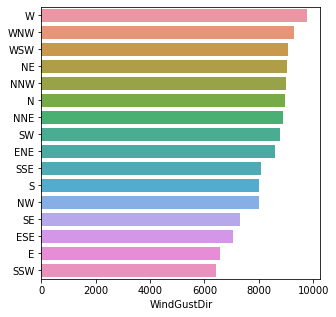

In [ ]:
var = 'WindGustDir'
plt.rcParams['figure.figsize'] = (5,5)
sns.barplot(df[var].value_counts() ,df[var].dropna().unique());

Para codificar las tres variables 'WindGustDir', 'WindDir9am' y 'WindDir3pm' utilizamos la siguiente conversión a grados sexagesimales.

In [ ]:
# transformamos las direcciones en grados con el diccionario
wind = {'W': 270, 'WNW': 292.5, 'WSW': 247.5, 'NE': 45, 'NNW': 337.5, 'N': 0, 'NNE': 22.5, 'SW': 225, 'ENE': 67.5, 'SSE': 157.5, 'S': 180, 'NW': 315, 'SE': 135, 'ESE': 112.5, 'E': 90, 'SSW': 202.5}
# pd.DataFrame(list(wind.items()), columns = ['Punto de compás','Dirección del viento']).to_latex() 

\begin{tabular}{llr}
\toprule
{} & Punto de compás &  Dirección del viento \\
\midrule
0  &               W &                 270.0 \\
1  &             WNW &                 292.5 \\
2  &             WSW &                 247.5 \\
3  &              NE &                  45.0 \\
4  &             NNW &                 337.5 \\
5  &               N &                   0.0 \\
6  &             NNE &                  22.5 \\
7  &              SW &                 225.0 \\
8  &             ENE &                  67.5 \\
9  &             SSE &                 157.5 \\
10 &               S &                 180.0 \\
11 &              NW &                 315.0 \\
12 &              SE &                 135.0 \\
13 &             ESE &                 112.5 \\
14 &               E &                  90.0 \\
15 &             SSW &                 202.5 \\
\bottomrule
\end{tabular}


Aplicada la transformación, las columnas quedan de la siguiente manera

In [ ]:
df_wind = pd.DataFrame()
df_wind['WindGustDir'] = df['WindGustDir'].astype('category')
df_wind['WindDir9am']  = df['WindDir9am'].astype('category')
df_wind['WindDir3pm']  = df['WindDir3pm'].astype('category')

df_wind['WindGustDir'] = df_wind['WindGustDir'].cat.rename_categories(wind).astype('float')
df_wind['WindDir9am']  = df_wind['WindDir9am'].cat.rename_categories(wind).astype('float')
df_wind['WindDir3pm']  = df_wind['WindDir3pm'].cat.rename_categories(wind).astype('float')

# df_wind.head().to_latex(index = False)

\begin{tabular}{rrr}
\toprule
 WindGustDir &  WindDir9am &  WindDir3pm \\
\midrule
       270.0 &       270.0 &       292.5 \\
       292.5 &       337.5 &       247.5 \\
       247.5 &       270.0 &       247.5 \\
        45.0 &       135.0 &        90.0 \\
       270.0 &        67.5 &       315.0 \\
\bottomrule
\end{tabular}


Luego, como las distancias entre grados no son lineales, convertimos cada dirección del viento en dos columnas, correspondientes a sus proyecciones en el eje horizontal y vertical.

In [ ]:
df_wind['WindGustDir_sin'] = np.sin(np.pi*df_wind['WindGustDir']/180)
df_wind['WindGustDir_cos'] = np.cos(np.pi*df_wind['WindGustDir']/180)

df_wind['WindDir3pm_sin'] = np.sin(np.pi*df_wind['WindDir3pm']/180)
df_wind['WindDir3pm_cos'] = np.cos(np.pi*df_wind['WindDir3pm']/180)

df_wind['WindDir9am_sin'] = np.sin(np.pi*df_wind['WindDir9am']/180)
df_wind['WindDir9am_cos'] = np.cos(np.pi*df_wind['WindDir9am']/180)

df_wind.drop(columns = ['WindGustDir','WindDir3pm','WindDir9am'], inplace = True)
# df_wind.head().to_latex(index = False)

\begin{tabular}{rrrrrr}
\toprule
 WGustDir\_sin &  WGustDir\_cos &  WDir3pm\_sin &  WDir3pm\_cos &  WDir9am\_sin &  WDir9am\_cos \\
\midrule
       -1.000000 &    -1.836970e-16 &       -0.923880 &    3.826834e-01 &       -1.000000 &   -1.836970e-16 \\
       -0.923880 &     3.826834e-01 &       -0.923880 &   -3.826834e-01 &       -0.382683 &    9.238795e-01 \\
       -0.923880 &    -3.826834e-01 &       -0.923880 &   -3.826834e-01 &       -1.000000 &   -1.836970e-16 \\
        0.707107 &     7.071068e-01 &        1.000000 &    6.123234e-17 &        0.707107 &   -7.071068e-01 \\
       -1.000000 &    -1.836970e-16 &       -0.707107 &    7.071068e-01 &        0.923880 &    3.826834e-01 \\
\bottomrule
\end{tabular}


### Location
Esta variable es codificada directamente utilizando one-hot-encoding. Como resultado se obtienen 48 columnas que indican si el registro pertenece a una ciudad.

Ciudades distintas: 49


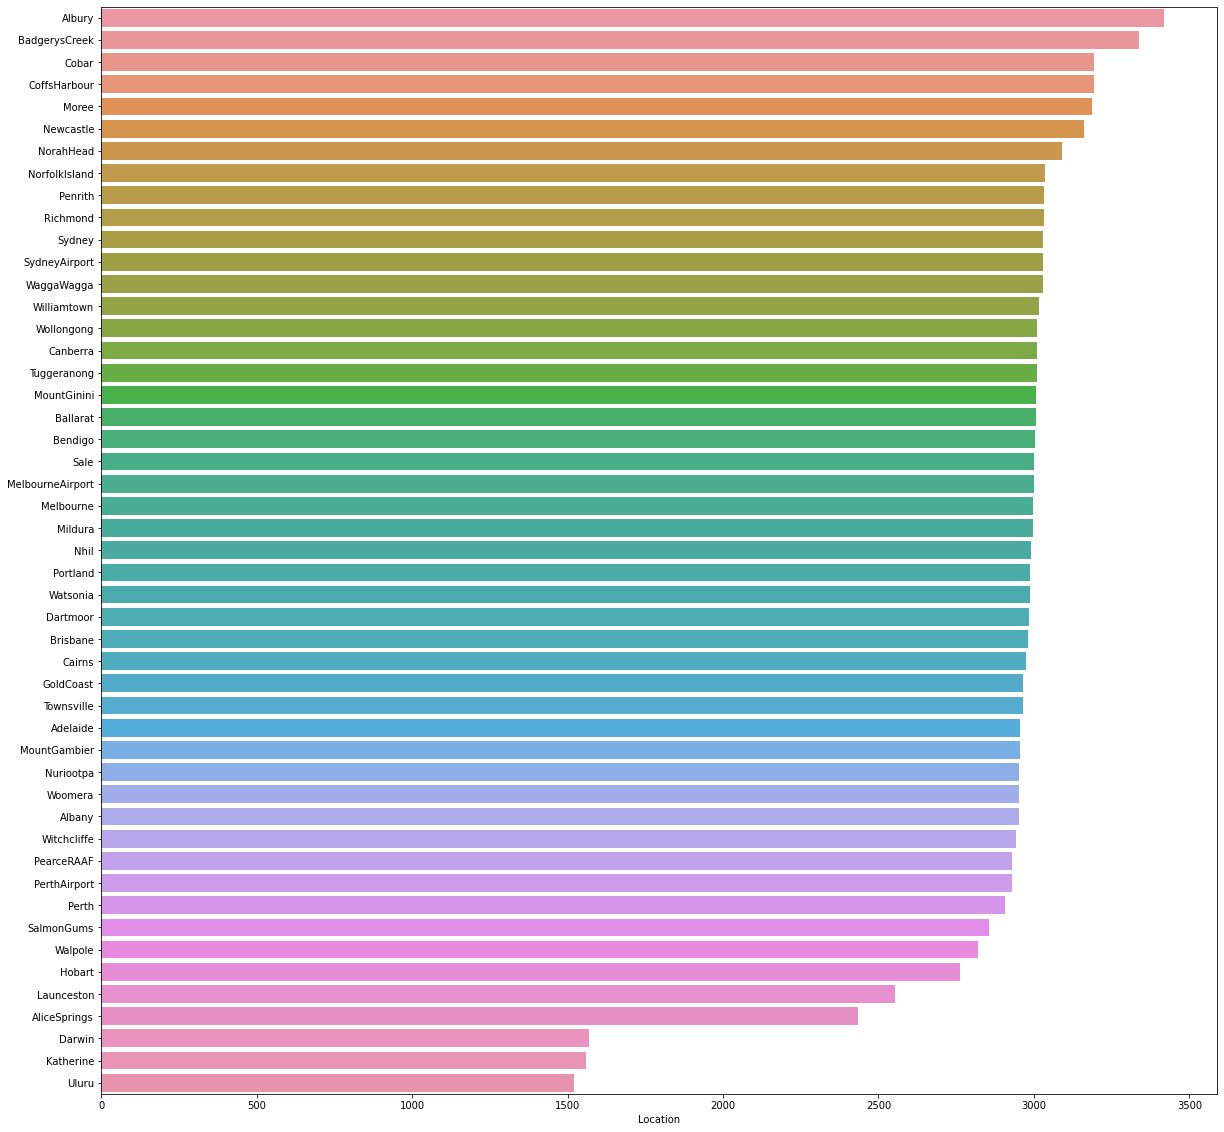

In [ ]:
plt.rcParams['figure.figsize'] = (20,20)
# numero de ciudades distintas
print("Ciudades distintas: " + str(df['Location'].nunique()))
sns.barplot(df['Location'].value_counts() ,df['Location'].unique());
plt.rcParams['figure.figsize'] = (20,10);
plt.show();

In [ ]:
df_city = pd.get_dummies(df['Location'], drop_first=True, prefix = 'city')
# df_city

In [ ]:
df_cat_coded = pd.concat([df_wind,df_season, df_city], axis = 1)
# df_cat_coded7,7

### RainToday y RainTomorrow

Estas variables son del tipo binarias, mediante las graficas de barras se observa que la proporción de casos es aproximadamente la misma en ambas clases. Lo cual tiene sentido. 

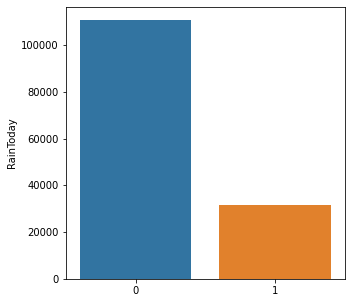

In [ ]:
df_cat_coded['RainToday']    = pd.get_dummies(df['RainToday'],drop_first = True)
df_cat_coded['RainTomorrow'] = pd.get_dummies(df['RainTomorrow'],drop_first = True)

plt.rcParams['figure.figsize'] = (5,5)
sns.barplot(x = df_cat_coded['RainToday'].dropna().unique(), y = df_cat_coded['RainToday'].value_counts());

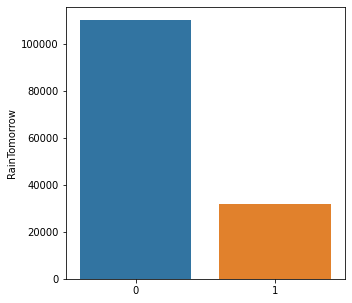

In [ ]:
plt.rcParams['figure.figsize'] = (5,5)
sns.barplot(x = df_cat_coded['RainTomorrow'].dropna().unique(), y = df_cat_coded['RainTomorrow'].value_counts());

## Variables numéricas

Todas las variables numéricas son transformadas mediante un StandardScaler a fines de optimizar el proceso para la obtención de los modelos.

In [ ]:

# Warning: esto tarda y no jode (+1 h)
# sns.pairplot(data = MiceImputed, hue = 'RainTomorrow', corner = True)

# ejecutar antes de ir a preparar el mate
# df_num = pd.concat([df.loc[:,df.dtypes == 'float64'],df['RainTomorrow']], axis = 1)
# sns.pairplot(data = df_num, hue = 'RainTomorrow', corner = True)
# df_num


### Correlación

A continuación, se inspeccionan las variables en búsqueda de correlaciones:

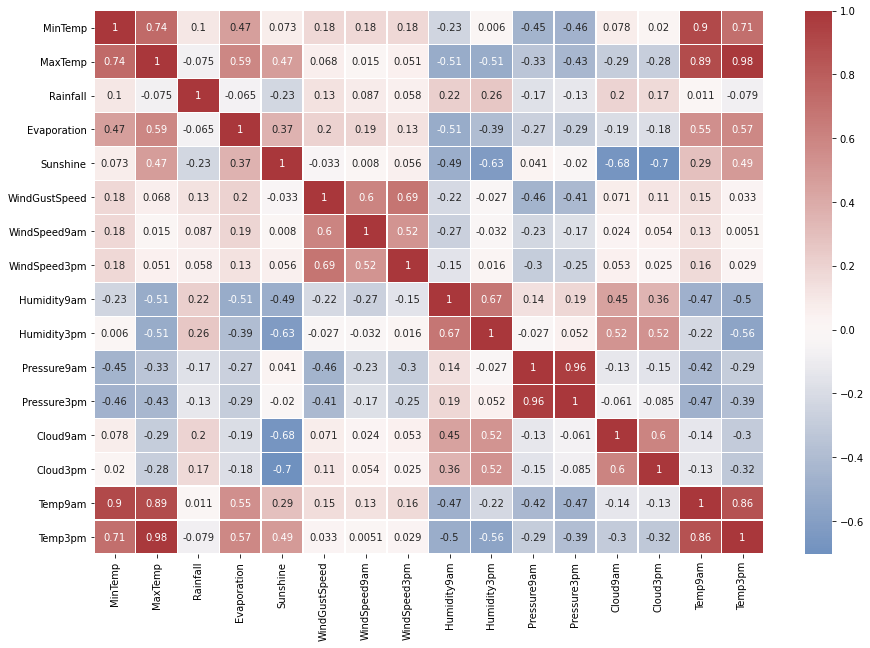

In [ ]:
df_num = df.select_dtypes('float64')
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(df_num.corr(), annot=True, linewidths=.5, ax=ax, cmap="vlag", center = 0);

* Existe una colinearidad muy alta entre 'Temp3pm' y 'Maxtemp'. Por lo que consideramos eliminar la variable 'Temp3pm' ya que tiene más valores vacíos.
* También, Temp9am tiene una alta correlación con MinTemp y MaxTemp, probablemente son linealmente estimadas. Por lo que se decide descartar Temp9m.
* Además, se observa alta correlación entre las mediciones de presión 'Pressure9am' y 'Pressure3pm', se descarta 'Pressure9am' ya que la lectura es realizada más temprano, por lo tanto, tendrá menos relación con la lluvia al siguiente día.

Estas variables serán descartadas para los algoritmos lineales, como regresión lineal y discriminantes lineales, que son afectados por la colinealidad de los predictores. Otros algoritmos iterativos como los árboles de decisión, no se ven tan afectados.

In [ ]:
df_descorr = df.drop(columns = ['Temp3pm','Temp9am','Pressure9am'])

**Predictores descorrelacionados**

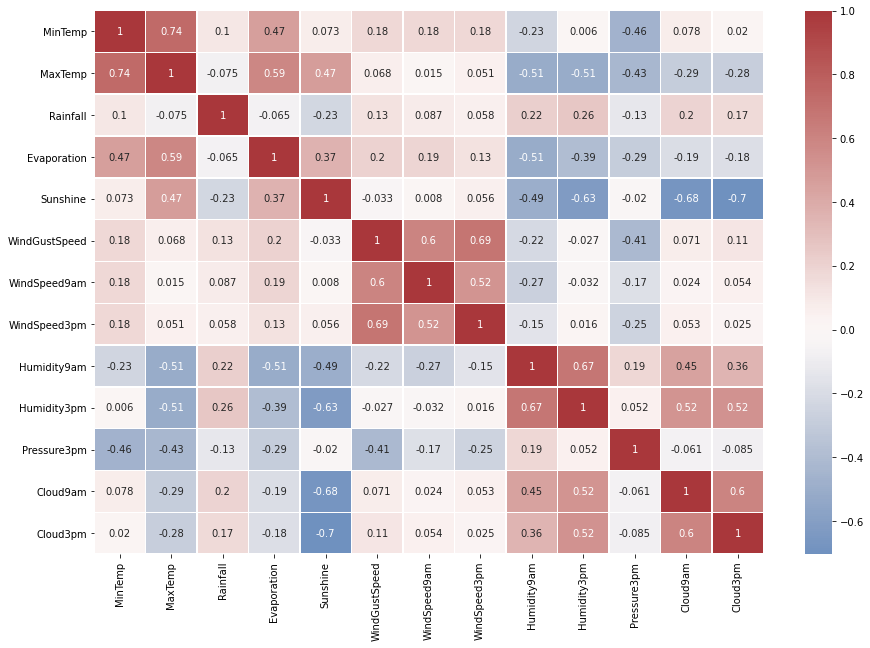

In [ ]:
# 
df_num = df_descorr.select_dtypes('float64')
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(df_num.corr(), annot=True, linewidths=.5, ax=ax, cmap="vlag", center = 0);

Luego de descartar las variables mencionadas anteriormente, se observa que no existe problemas de multicolinearidad en el set de datos.

\newpage

In [ ]:
# descorrelacionadas + variables categoricas codificadas 
df_eng = pd.concat([df_descorr.select_dtypes('float64','uint8'), df_cat_coded], axis = 1)

# df_eng

### Outliers

Para identificar las variables con outliers, se realizan diagramas de caja y bigote.

In [ ]:
df_num = df_eng.select_dtypes('float64')
# df_num.shape

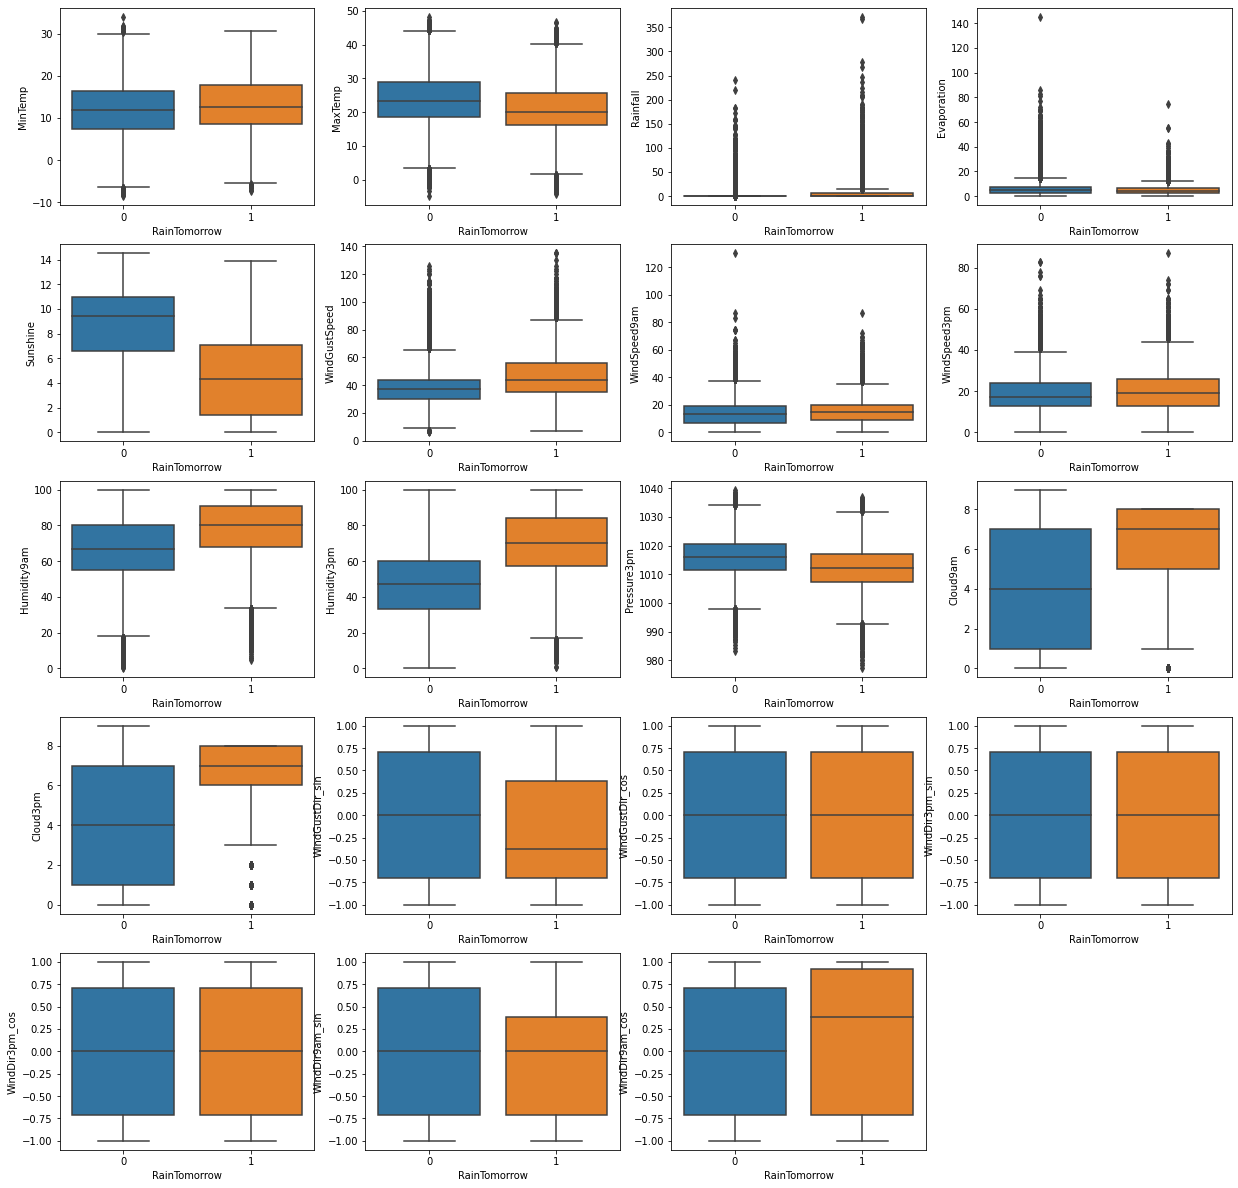

In [ ]:
plt.rcParams['figure.figsize'] = (21,21)
for i, col in enumerate(df_num.columns, 1):
    plt.subplot(5,4,i) 
    ax = sns.boxplot(y = col , x = "RainTomorrow", data = df_eng)
    # ax = sns.swarmplot(x = col, y = "RainTomorrow", data = df, color=".25")

Mediante una inspección visual y siendo muy flexibles podríamos decir que 'Rainfall', 'Evaporation' y 'WindSpeed9am' tienen valores atípicos.

#### **Descarte por inspección visual**

Descartamos por inspección visual los outliers más evidentes en las variables mencionadas arriba. El resultado es el siguiente

In [ ]:
# opcion 1
df_out1 = df_eng.drop(index = df_eng.query('Rainfall > 300 | Evaporation > 120 | WindSpeed9am > 120').index, axis = 1)

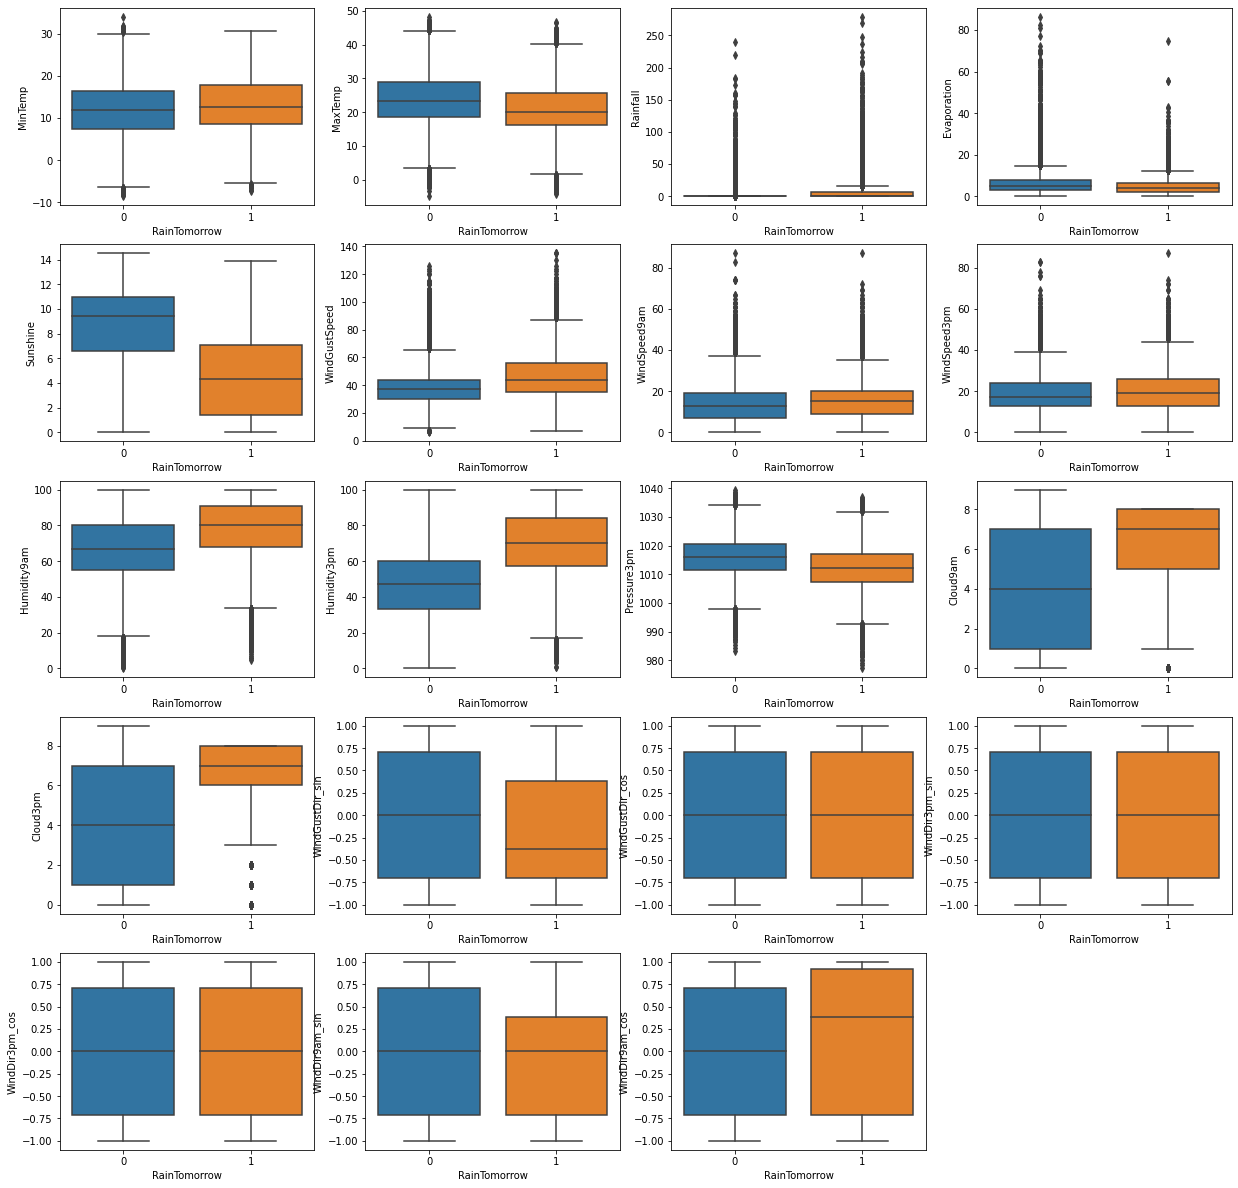

In [ ]:
df_num = df_out1.select_dtypes('float64')
plt.rcParams['figure.figsize'] = (21,21)

for i, col in enumerate(df_num.columns, 1):
    plt.subplot(5,4,i) 
    ax = sns.boxplot(y = col , x = "RainTomorrow", data = df_out1)
    # ax = sns.swarmplot(x = col, y = "RainTomorrow", data = df, color=".25")

**Descarte por zscore**

En este caso, descartamos aquellos valores que superen el valor de 3 en el *zscore* de la variable estandarizada.

In [ ]:
df_num = df_eng.select_dtypes('float64')
df_cat = df_eng.select_dtypes(['object','uint8'])

id_inliers = (np.abs(stats.zscore(df_num, nan_policy='omit')) < 3).all(axis=1)

df_num_out = df_num.loc[id_inliers].copy()
df_cat = df_cat.loc[id_inliers].copy()

df_out2 = pd.concat([df_num_out, df_cat], axis = 1)
# df_out2.head()

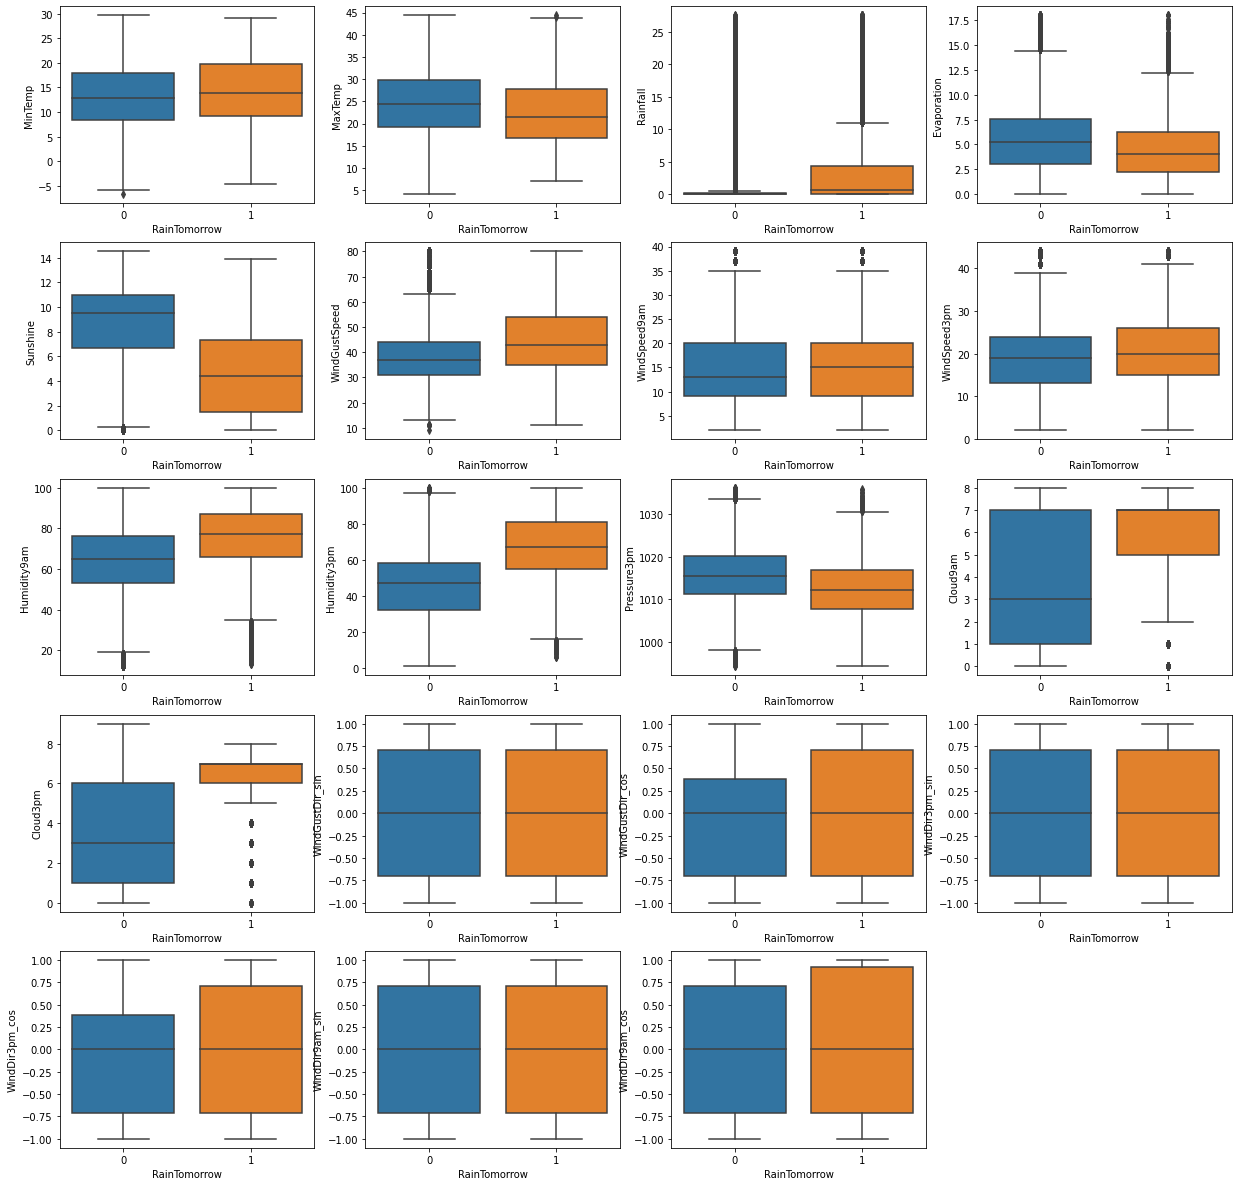

In [ ]:
plt.rcParams['figure.figsize'] = (21,21)
df_num = df_out2.select_dtypes('float64')

for i, col in enumerate(df_num.columns, 1):
    plt.subplot(5,4,i) 
    ax = sns.boxplot(y = col , x = "RainTomorrow", data = df_out2)
    # ax = sns.swarmplot(x = col, y = "RainTomorrow", data = df, color=".25")

Se obtienen distribuciones más simétricas. Sobre todo en las variables 'WindSpeed9am', 'WindSpeed3am' y 'Evaporation'.

# Modelo Base: Dataset original, descarte de registros vacíos

La construcción de modelos la realizamos experimentando con diferentes configuraciones de datos para estudiar la influencia de las transformaciones realizadas en el desempeño de los modelos.

En primer lugar, se optará por la eliminación de las filas con datos faltantes y la consideración de las variables del tipo numéricas.
Posteriormente, se incluirán las variables categóricas con las transformaciones mencionadas.

La alternativa siguiente consistirá en la imputación de los datos faltantes, a fines de maximizar la disponibilidad de información del set original. Dentro de la imputación, se emplearán técnicas de regresión, con el objetivo de no modificar la distribución de los datos de cada columna (inconveniente que podría ocurrir utilizando la media por ejemplo).

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Funcion para visualizaciones
def info_result(y_true, y_pred, model=None):
    roc_auc = roc_auc_score(y_true, y_pred) 
    accuracy  = metrics.accuracy_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    f1        = metrics.f1_score(y_test, y_pred)
    AUC       = metrics.roc_auc_score(y_test, y_pred)
 
    scores = pd.DataFrame(data = [accuracy, recall, precision, f1, AUC],
               index = ['Accuracy','Recall','Precision','F1','AUC'],
               columns = [type(model).__name__])

    return scores

In [ ]:
## FUNCIONES MODELADO
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

def train_pipe(pipe, X_train, y_train, X_test, y_test, pipe_name):
  # imprime el score de CV
  k_folds = 5
  cv_acc = cross_val_score(pipe, X_train, y_train, cv = k_folds, scoring = 'accuracy')
  cv_rec = cross_val_score(pipe, X_train, y_train, cv = k_folds, scoring = 'recall')
  cv_pre = cross_val_score(pipe, X_train, y_train, cv = k_folds, scoring = 'precision')
  cv_f1  = cross_val_score(pipe, X_train, y_train, cv = k_folds, scoring = 'f1')
  cv_auc = cross_val_score(pipe, X_train, y_train, cv = k_folds, scoring = 'roc_auc')
  # print('Scores train CV ' + pipe_name + ' :')
  scores = pd.DataFrame(data = [cv_acc.mean(), cv_rec.mean(), cv_pre.mean(), cv_f1.mean(), cv_auc.mean()],
               index = ['Accuracy','Recall','Precision','F1','AUC'],
               columns = [pipe_name])
  scores
  # fit model
  pipe.fit(X_train, y_train)
  return pipe, scores

def fit_pipe(pipe, X_train, y_train, X_test, y_test, pipe_name):
  # test
  y_hat = pipe.predict(X_test)
 
  # metrics.plot_confusion_matrix(pipe, X_test, y_test, cmap = plt.cm.Blues)
  accuracy  = metrics.accuracy_score(y_test, y_hat)
  recall    = metrics.recall_score(y_test, y_hat)
  precision = metrics.precision_score(y_test, y_hat)
  f1        = metrics.f1_score(y_test, y_hat)
  AUC       = metrics.roc_auc_score(y_test, y_hat)
 
  scores = pd.DataFrame(data = [accuracy, recall, precision, f1, AUC],
               index = ['Accuracy','Recall','Precision','F1','AUC'],
               columns = [pipe_name])

  # metrics.plot_roc_curve(pipe, X_test, y_test)
  # plt.show() 
  return pipe, scores


In [ ]:
## FUNCIONES VISUALIZACION

  # Funcion para graficar matriz de confusión
def conf_matrix(y_test, pred_y):
    LABELS = ["No", "Yes"]
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Matriz de Confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')
    plt.show()

      # Funcion para graficar matriz de confusión pipes
def pipe_conf_matrix(pipes, X_test, y_test):
    LABELS = ["No", "Yes"]
    plt.rcParams['figure.figsize'] = (15,4)
    fig, axs = plt.subplots(nrows=1, ncols = len(pipes))

    for pipe, ax in zip(pipes, axs):
        y_hat = pipe.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_hat)
        sns.heatmap(conf_matrix, 
                    xticklabels = LABELS,
                    yticklabels = LABELS,
                    annot=True,
                    fmt="d",
                    ax = ax,
                    cbar = False).set(
                        title = type(pipe[1]).__name__,
                        xlabel = 'Clase predicha',
                        ylabel = 'Clase real')

# Funcion para graficar las curvas ROC de un array de pipes
def pipe_rocs(pipes, X_test, y_test):
    fig, ax = plt.subplots()
    for pipe in pipes:
        metrics.plot_roc_curve(pipe, X_test, y_test, ax = ax, name = type(pipe[1]).__name__)
    plt.rcParams['figure.figsize'] = (15,15)
    plt.show()

In [ ]:
## data sets para pruebas
# * df: original
# * df_nona: original sin nans
# * df_eng: set resultado de la ingeniería de variables
# * df_out1: df_eng sin outliers mas grosos
# * df_out2: df_eng sin outliers descartados por zscore > 3


In [ ]:
### Parámetros 

# train/test split
test_ratio = 0.5

#logistic regression
max_iter_lr = 1000

#random forest
n_estimators_rf = 100       #default: 100
max_features_rf = 0.3       #default:'auto'
max_depth_rf = None         #default: None
min_samples_leaf_rf = 1     #default: 1

#decisiontree
params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

In [ ]:
def supreme_pipe(X_train, y_train, X_test, y_test):
    # Logistic
    pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=max_iter_lr, solver='liblinear', random_state=0))
    pipe_lr, cv_scores_lr = train_pipe(pipe_lr, X_train, y_train, X_test, y_test, 'Logistic')
    pred = pipe_lr.predict(X_test)

    # LDA
    pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
    pipe_lda, cv_scores_lda = train_pipe(pipe_lda, X_train, y_train, X_test, y_test, 'LDA')
    pred = pipe_lda.predict(X_test)

    # GaussianNB
    pipe_GNB = make_pipeline(StandardScaler(), GaussianNB())
    pipe_GNB, cv_scores_GNB = train_pipe(pipe_GNB, X_train, y_train, X_test, y_test, 'GaussianNB')
    pred = pipe_GNB.predict(X_test)

    # RandomForest
    pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(
        n_estimators = n_estimators_rf,
        max_features = max_features_rf,
        max_depth = max_depth_rf,
        min_samples_leaf = min_samples_leaf_rf
    ))
    pipe_rf, cv_scores_rf = train_pipe(pipe_rf, X_train, y_train, X_test, y_test, 'RandomForest')
    pred = pipe_rf.predict(X_test)

    # DecisionTree
    pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier(**params_dt))
    pipe_dt, cv_scores_dt = train_pipe(pipe_dt, X_train, y_train, X_test, y_test, 'DecisionTree')
    pred = pipe_dt.predict(X_test)

    # print('TRAIN')
    cv_scores = pd.concat([cv_scores_lr, cv_scores_lda, cv_scores_GNB, cv_scores_rf, cv_scores_dt],axis = 1)
    # print(cv_scores)

    # ---- EVALUACION -----

    # Logistic
    pipe_lr, test_scores_lr = fit_pipe(pipe_lr, X_train, y_train, X_test, y_test, 'Logistic')
    # LDA
    pipe_lda, test_scores_lda = fit_pipe(pipe_lda, X_train, y_train, X_test, y_test, 'LDA')
    # GaussianNB
    pipe_GNB, test_scores_GNB = fit_pipe(pipe_GNB, X_train, y_train, X_test, y_test, 'GaussianNB')
    # RandomForest
    pipe_rf, test_scores_rf = fit_pipe(pipe_rf, X_train, y_train, X_test, y_test, 'RandomForest')
    # DecisionTree
    pipe_dt, test_scores_dt = fit_pipe(pipe_dt, X_train, y_train, X_test, y_test, 'DecisionTree')

    test_scores = pd.concat([test_scores_lr, test_scores_lda, test_scores_GNB, test_scores_rf, test_scores_dt],axis = 1)
    # print()
    # print('TEST')
    # print(test_scores)

    pipes = [pipe_lr, pipe_lda, pipe_GNB, pipe_rf, pipe_dt]
    return pipes, cv_scores, test_scores

# --- To evaluate or use ---
# pipes, cv_scores, test_scores = supreme_pipe(X_train, y_train, X_test, y_test)
# pipe_conf_matrix(pipes, X_test, y_test)

In [ ]:
# lo mas simple, seria droppear todos los NA y quedarnos con los registros confiables (DESCARTE)
# despues podemos probar completando datos                                            (IMPUTACIÓN)
df_nona = df.dropna(axis = 'index', how = 'any')
print('Tamaño del conjunto de datos:')
df_nona.shape

Tamaño del conjunto de datos:


(56420, 23)

## Variables numéricas

En esta sección, se presentan los resultados obtenidos considerando únicamente las variables del tipo numéricas del set original, con la eliminación de las entradas con datos faltantes. Los *scores* obtenidos servirán como una línea base, permitiendo definir un punto de comparación para los entrenamientos con procesamiento de las variables.

In [ ]:
# Preparamos el set de datos

# Salida
y = df_nona['RainTomorrow'].map( {'No':0, 'Yes':1} ) 
# Entrada
X = df_nona.drop(['RainTomorrow'], axis=  1)

# print("Prueba sin datos categoricos")
for date in datos_categoricos[:-1]:
    X = X.drop([date], axis=1)
    # print("Se quitó: ", date)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state=0)
# X_train.shape

In [ ]:
pipes, cv_scores, test_scores = supreme_pipe(X_train, y_train, X_test, y_test)

**Scores CV set de entrenamiento**

In [ ]:
# cv_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.854 &  0.851 &       0.801 &         0.856 &         0.802 \\
Recall    &     0.526 &  0.534 &       0.682 &         0.523 &         0.512 \\
Precision &     0.731 &  0.715 &       0.536 &         0.744 &         0.545 \\
F1        &     0.612 &  0.611 &       0.600 &         0.612 &         0.538 \\
AUC       &     0.883 &  0.882 &       0.849 &         0.887 &         0.709 \\
\bottomrule
\end{tabular}


**Scores set evaluación**

In [ ]:
# test_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.854 &  0.853 &       0.800 &         0.860 &         0.804 \\
Recall    &     0.537 &  0.548 &       0.687 &         0.528 &         0.527 \\
Precision &     0.733 &  0.722 &       0.539 &         0.765 &         0.562 \\
F1        &     0.620 &  0.623 &       0.604 &         0.625 &         0.544 \\
AUC       &     0.741 &  0.744 &       0.760 &         0.741 &         0.705 \\
\bottomrule
\end{tabular}



* De forma general, el valor de *Recall* obtenido es bajo para esta alternativa, dejando en evidencia un rendimiento pobre respecto a los falsos negativos. Este inconveniente puede mejorarse con una de las técnicas mencionadas para el balanceo del set de datos.
* El mejor *AUC* corresponde al Algoritmo de clasificación: *Gaussiano Naive-Bayes.*
* Además, la mayoría de modelos presenta una diferencia aproximada del **14%** entre el **AUC** del set para entrenamiento y el de test, dando pautas de la existencia de cierto *overfitting*.

In [ ]:
# matrices confusas
# pipe_conf_matrix(pipes, X_test, y_test)

In [ ]:
# pipes[3][1]

Del modelo Random Forest (RF), se realiza una gráfica para representar la importancia adoptada de las variables que intervienen en el modelo. Cabe resaltar que algunas de las variables con un mayor porcentaje de datos faltantes, se encuentran dentro de las variables con mayor importancia, identificadas por RF.

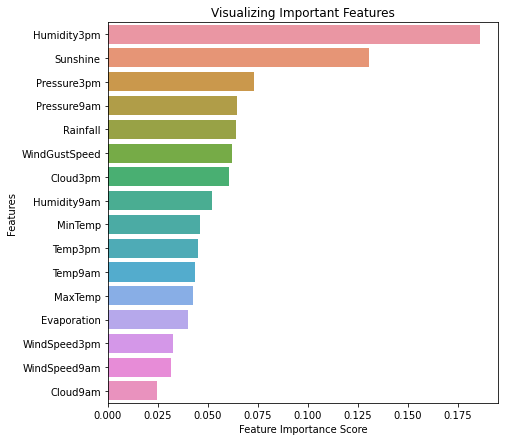

In [ ]:
# Visualizacion de la importancia de las variables en el modelo obtenido
plt.rcParams['figure.figsize'] = (7,7)
feature_imp = pd.Series(pipes[3][1].feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# La humedad de la tarde es la más influyente por lo visto, tiene sentido a la hora de querer predecir si llueve el día siguiente

## Variables numéricas balanceado
El set de datos bajo análisis, como ya se ha visto, presenta el conjunto de datos desequilibrados, por lo tanto el modelo puede no aprender bien respecto a la clase minoritaria (días que "Si" llueve). Este problema, en cierta manera puede verse reflejado en el *Recall* de los últimos resultados. 

Como alternativa a este inconveniente, se procede a la generación de nuevas entradas para la clase minoritaria, a fines de lograr una salida más balanceada. Esto se lleva a cabo sobre el set de entrenamiento únicamente. 
Para las nuevas entradas, se aplica el método *SMOTE-Tomek*, que es una técnica de sobremuestreo de minorías sintéticas que a su vez se combina con submuestreo.

A modo comparativo, se indican las cantidades asociadas a cada clase, previo y posterior a la acción del balanceo. Se utilizó un ratio de **0.8**, es decir, la clase minoritaria pasa a conformarse por un número de entradas que equivale al **80 %** de la clase mayoritaria.


In [ ]:
## preparacion data set balanceado
os_us = SMOTETomek(ratio=0.8)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

print("Distribución antes: ")
print(y_train.value_counts().to_string())
print("Distribución despues: ")
print(pd.DataFrame(data = y_train_res).value_counts().to_string())

Distribución antes: 
0    22035
1     6175
Distribución despues: 
0    21910
1    17503


In [ ]:
pipes, cv_scores, test_scores = supreme_pipe(X_train_res, y_train_res, X_test, y_test)

Con estas especificaciones, se obtienen los resultados presentados a continuación. Correspondientes tanto al set de entrenamiento como el de pruebas o evaluación.

**Scores CV set de entrenamiento**

In [ ]:
# cv_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.803 &  0.800 &       0.775 &         0.896 &         0.820 \\
Recall    &     0.754 &  0.743 &       0.765 &         0.883 &         0.810 \\
Precision &     0.792 &  0.793 &       0.738 &         0.882 &         0.794 \\
F1        &     0.773 &  0.767 &       0.751 &         0.879 &         0.804 \\
AUC       &     0.889 &  0.888 &       0.855 &         0.964 &         0.842 \\
\bottomrule
\end{tabular}


**Scores set evaluación**

In [ ]:
# test_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.818 &  0.820 &       0.774 &         0.851 &         0.787 \\
Recall    &     0.754 &  0.742 &       0.755 &         0.634 &         0.607 \\
Precision &     0.568 &  0.572 &       0.493 &         0.674 &         0.517 \\
F1        &     0.648 &  0.646 &       0.597 &         0.653 &         0.558 \\
AUC       &     0.795 &  0.792 &       0.767 &         0.773 &         0.723 \\
\bottomrule
\end{tabular}


* Como se observa en las métricas, con el hecho de balancear el set de entrenamiento, los resultados mejoran considerablemente. Ahora se tiene un *Recall* en el orden de **0.75**, en contraste al anterior de **0.5**.
* El modelo Random Forest presenta cierto grado de *overfitting*, las diferencias entre las métricas de entrenamiento y test son las mayores.
* Los mejores modelos son el de Regresión Logística y el Gaussiano, y les sigue muy de cerca el de Random Forest.

In [ ]:
# print(pipes[1][1].intercept_)
# print(pipes[1][1].coef_)

In [ ]:
# Para estos resultados, se presenta la matriz de confusión asociada:

In [ ]:
# matrices confusas
# pipe_conf_matrix(pipes, X_test, y_test)

Dentro de las variables o características que el modelo de Random Forest determina más significativas o importantes, se presenta a continuación una gráfica según su orden de importancia:

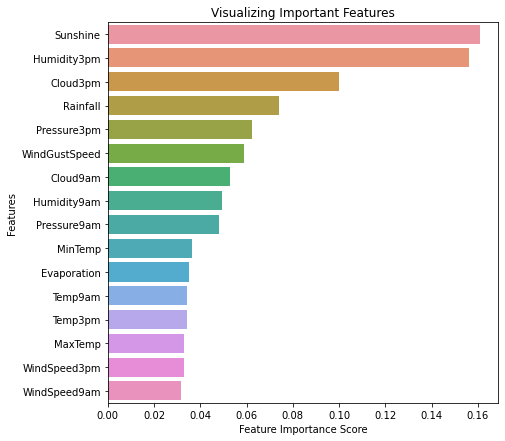

In [ ]:
# Visualizacion de la importancia de las variables en el modelo obtenido
plt.rcParams['figure.figsize'] = (7,7)

feature_imp = pd.Series(pipes[3][1].feature_importances_,index=X_train.columns.values).sort_values(ascending = False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

***Resumen***

Sin considerar las variables categóricas, se obtiene para los mejores modelos un *ROC* aproximado de: **0.79**


## Considerando variables categóricas no balanceado


En esta prueba, se incluyen las variables categóricas del set de datos. Para su utilización preliminar, se recurrió a una codificación sencilla en dónde se mapea cada elemento de una categoría con un valor entero. En forma resumida, este método tranforma una variable categórica en una ordinal. Para la columna de "*date*", en esta transformación se consideraron los meses únicamente.

Este tipo de codificación no es el adecuado para los datos en el contexto que se tiene porque establablece un ranking de acuerdo al entero asignado, es decir, una suerte de escala en dónde los valores más altos serán considerados como "más importantes" (se aclaró con mayor detalle, en secciones anteriores, este fenómeno).

Este ensayo se realiza para conformar una base respecto a la mejora de los modelos con la inclusión de estas variables. Posteriormente, se contrastará con lo que se obtiene al codificar estas variables de acuerdo al análisis individual de cada una, efectuado anteriormente.

Los modelos se comportan de la siguiente manera:

In [ ]:
# preparamos el data set
df_nona_cat_map = df_nona.copy()

df_nona_cat_map['RainTomorrow'] = df_nona_cat_map['RainTomorrow'].map({'No':0, 'Yes':1})
df_nona_cat_map['RainToday'] = df_nona_cat_map['RainToday'].map({'No':0, 'Yes':1})
df_nona_cat_map['Date'] = pd.to_datetime(df_nona_cat_map['Date']).dt.month # Se considera el mes primero

# print("Prueba con datos categoricos")
for column in datos_categoricos[:-2]:
    l = df_nona_cat_map[column].value_counts().index.tolist() 
    mapping = {x:y for x,y in zip(l, range(len(l)))}
    df_nona_cat_map[column] = df_nona_cat_map[column].map(mapping)
    # print("Se transformó: ", column)

# Salida
y = df_nona_cat_map['RainTomorrow']
# Entrada
X = df_nona_cat_map.drop(['RainTomorrow'], axis=  1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)


In [ ]:
pipes, cv_scores, test_scores = supreme_pipe(X_train, y_train, X_test, y_test)

**Scores CV set de entrenamiento**

In [ ]:
# cv_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.852 &  0.852 &       0.802 &         0.858 &         0.802 \\
Recall    &     0.527 &  0.544 &       0.683 &         0.527 &         0.508 \\
Precision &     0.724 &  0.711 &       0.538 &         0.748 &         0.557 \\
F1        &     0.610 &  0.616 &       0.602 &         0.620 &         0.520 \\
AUC       &     0.884 &  0.883 &       0.849 &         0.888 &         0.710 \\
\bottomrule
\end{tabular}


**Scores set evaluación**

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.856 &  0.853 &       0.802 &         0.862 &         0.808 \\
Recall    &     0.546 &  0.556 &       0.690 &         0.535 &         0.516 \\
Precision &     0.735 &  0.719 &       0.542 &         0.770 &         0.576 \\
F1        &     0.627 &  0.627 &       0.607 &         0.631 &         0.544 \\
AUC       &     0.745 &  0.747 &       0.762 &         0.745 &         0.704 \\
\bottomrule
\end{tabular}


Los resultados anteriores corresponden al set de datos sin los datos faltantes, con la codificación de las categoricas a ordinales, sin balanceo. Es decir, que para determinar la influencia de las categóricas, estos resultados pueden compararse con los primeros obtenidos al realizar pruebas sobre el set de datos sin los datos faltantes, y considerando únicamente las variables numéricas.

Al comparar ambas tablas, se deduce que *la adición de los categóricos no mejora los resultados de los modelos*. En principio, no con este tipo de codificación.

Para dar un contraste numérico, en ambos casos el mejor modelo fue el Gaussiano. Sin categóricas se obtuvo un *ROC* de **0.76** y con las categóricas **0.762**.

Finalmente, a modo de representar la importancia de las variables categóricas, se realiza una gráfica de acuerdo a la importancia asumida por el modelo Random Forest. En la gráfica se presentan todas las variables incluidas en los modelos, pero, se aprecia que las categóricas se hallan mayormente en los valores más bajos.

In [ ]:
# test_scores.to_latex()

In [ ]:
# matrices confusas
# pipe_conf_matrix(pipes, X_test, y_test)

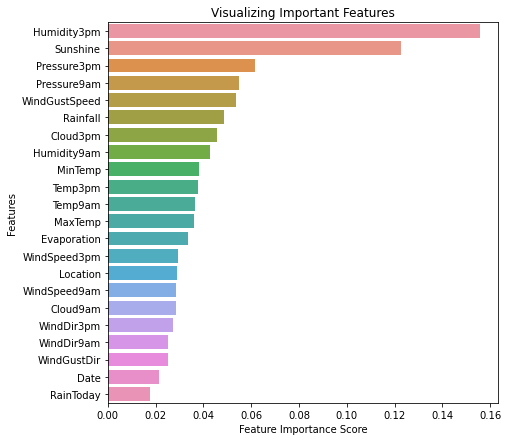

In [ ]:
# Visualizacion de la importancia de las variables en el modelo obtenido
plt.rcParams['figure.figsize'] = (7,7)
feature_imp = pd.Series(pipes[3][1].feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Análisis de Resultados sobre el modelo base

Considerando las variables categoricas, se obtiene el mejor *ROC* para el modelo *Gaussiano Naive-Bayes*. El mismo corresponde a **0.76**, además, de los mejores modelos, este es el que menos variaciones presenta en los *scores* entre el set de entrenamiento y el de *test*.


# Manejo de Datos Faltantes

## Quitando columnas con mayoría de datos faltantes
Al quitar *Evaporation*, *Sunshine*, *Cloud3pm* y *Cloud9am*; el set de datos para el entrenamiento será considerablemente mayor al de la *Prueba 1*.
Esto no garantiza mejores resultados de todas maneras, ya que *Sunshine* por ej, está 2do dentro de la importancia de las variables en el modelo Random Forest obtenido en la *Prueba 1*.

A continuación se presenta el conteo de los valores de salida (*RainTomorrow*) para los datos con este tratamiento, y los resultantes al realizar el balanceo.

Contrastando numéricamente, en los ensayos anteriores se tenían aproximadamente **22000** entradas y ahora se tienen casi **44000**, es decir, un incremento del doble. Esto se condice con los valores computados respecto a los datos faltantes en las columnas que se han eliminado para esta prueba (Por ej: *Sunshine* con casi **48%** de faltantes).

In [ ]:
# Se quitan la columnas con un gran porcentaje de datos faltantes
df_drop = df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1)
df_drop = df_drop.dropna(axis = 'index', how = 'any')

d_categoricos = [col for col in df_drop.columns if df_drop[col].dtypes=="object"]
d_numericos = [col for col in df_drop.columns if col not in d_categoricos]


df_drop['RainTomorrow'] = df_drop['RainTomorrow'].map({'No':0, 'Yes':1})
df_drop['RainToday'] = df_drop['RainToday'].map({'No':0, 'Yes':1})
df_drop['Date'] = pd.to_datetime(df_drop['Date']).dt.month # Se considera el mes

# print("Procesando categoricos")
for column in d_categoricos[:-2]:
    l = df_drop[column].value_counts().index.tolist() 
    mapping = {x:y for x,y in zip(l, range(len(l)))}
    df_drop[column] = df_drop[column].map(mapping)
    # print("Se transformó: ", column)

# Salida
y = df_drop['RainTomorrow']
# Entrada
X = df_drop.drop(['RainTomorrow'], axis=  1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state=0)

# Balanceo del set
os_us = SMOTETomek(ratio=0.8)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

print("Distribución antes: ")
print(y_train.value_counts().to_string())
print("Distribución despues: ")
print(pd.DataFrame(data = y_train_res).value_counts().to_string())
# X_train.head()

Distribucion antes: Counter({0: 43932, 1: 12530})
Distribucion despu: Counter({0: 43691, 1: 34904})


En las tablas siguiente, se tienen los resultados tanto para el set de entramiento como el de test:

In [ ]:
pipes, cv_scores, test_scores = supreme_pipe(X_train_res, y_train_res, X_test, y_test)

**Scores CV set de entrenamiento**

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.793 &  0.791 &       0.749 &         0.892 &         0.814 \\
Recall    &     0.733 &  0.716 &       0.625 &         0.859 &         0.777 \\
Precision &     0.786 &  0.793 &       0.766 &         0.894 &         0.794 \\
F1        &     0.758 &  0.752 &       0.689 &         0.872 &         0.785 \\
AUC       &     0.871 &  0.870 &       0.826 &         0.963 &         0.840 \\
\bottomrule
\end{tabular}


In [ ]:
# cv_scores.to_latex()

**Scores set evaluación**

In [ ]:
# test_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.814 &  0.818 &       0.796 &         0.850 &         0.783 \\
Recall    &     0.735 &  0.718 &       0.639 &         0.605 &         0.600 \\
Precision &     0.560 &  0.570 &       0.532 &         0.681 &         0.508 \\
F1        &     0.636 &  0.636 &       0.580 &         0.641 &         0.550 \\
AUC       &     0.786 &  0.782 &       0.739 &         0.762 &         0.718 \\
\bottomrule
\end{tabular}


In [ ]:
# matrices confusas
# pipe_conf_matrix(pipes, X_test, y_test)

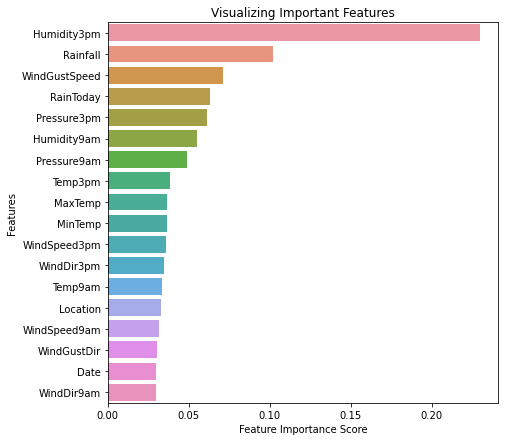

In [ ]:
# Visualizacion de la importancia de las variables en el modelo obtenido
plt.rcParams['figure.figsize'] = (7,7)
feature_imp = pd.Series(pipes[3][1].feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

**Resumen:**

Con el descarte de las columnas con cantidades significativas de datos faltantes, se obtiene para los modelos más significativos un *ROC* de:



* Logistic Regression:  78.5 %

* LDA:                  78.3 %

* Random Forest:        76.5 %



NOTA: Si bien existe una leve mejoría en los *scores*, es probable que se deba al incremento de entradas para el proceso de entrenamiento de los modelos. La importancia de las variables asumidas por el modelo Random Forest bajo esta prueba, resulta comparable a la anterior. Por lo tanto, con la eliminación directa de la columna *Sunshine* (que es muy significativa en pruebas anteriores), es probable que se esté perdiendo información significativa del fenómeno bajo análisis. Esto mismo podría estar ocurriendo con las demás variables descartadas por eliminación directa.
Lo más conveniente sería optar por un camino que considere la imputación de los faltantes mediante alguna técnica, y, de esta forma, procurar mejores *scores* en los modelos.

## Imputación de datos faltantes

Para evitar modificar la distribución de las diferentes columnas, se opta por utilizar un modelo de regresión para la imputación de los datos. Se ha escogido el algoritmo *MICE* (*Multiple Imputation by Chained Equations*) para este cometido.

De forma resumida, la imputación múltiple por ecuaciones encadenadas es un método robusto e informativo para tratar los datos faltantes en los conjuntos de datos. El procedimiento imputa los datos faltantes en un conjunto de datos a través de una serie iterativa de modelos predictivos. En cada iteración, cada variable especificada en el conjunto de datos se imputa utilizando las otras variables en el conjunto de datos. Estas iteraciones se ejecutan hasta alcanzar la convergencia.

https://cran.r-project.org/web/packages/miceRanger/vignettes/miceAlgorithm.html

In [ ]:
# import matplotlib.pyplot as plt

# df_num = df_nona[datos_numericos]
# df_num.hist(bins=50, figsize=(20,15))
# plt.show()

### MICE imputation + SMOTE balance

A continuación, se presetan los histogramas de cada variable incluida en esta prueba. En primer lugar, se observan las distribuciones para las variables originales, y, luego, las resultantes al imputar los faltantes con este método.

Además, con el proceso de imputación y balanceo, ahora se disponen de **54000** entradas para los procesos de entrenamiento y test de resultados.

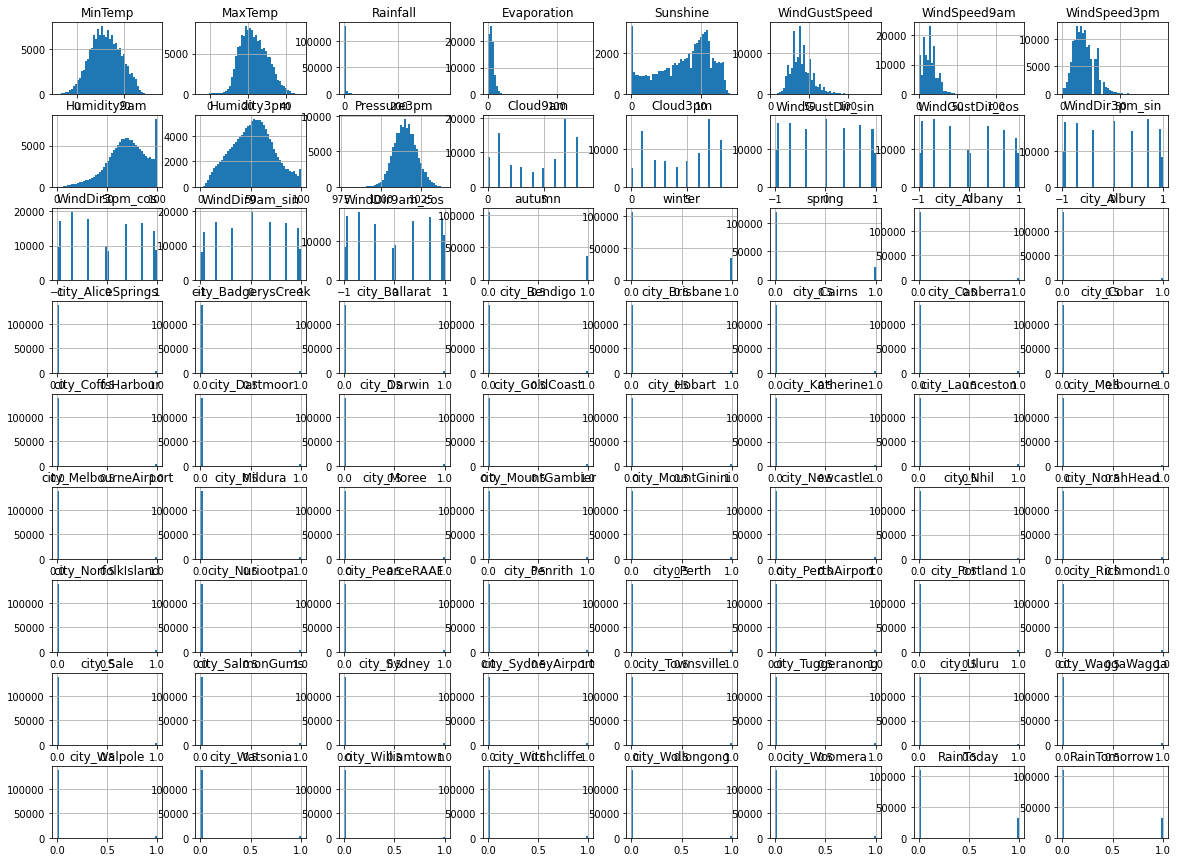

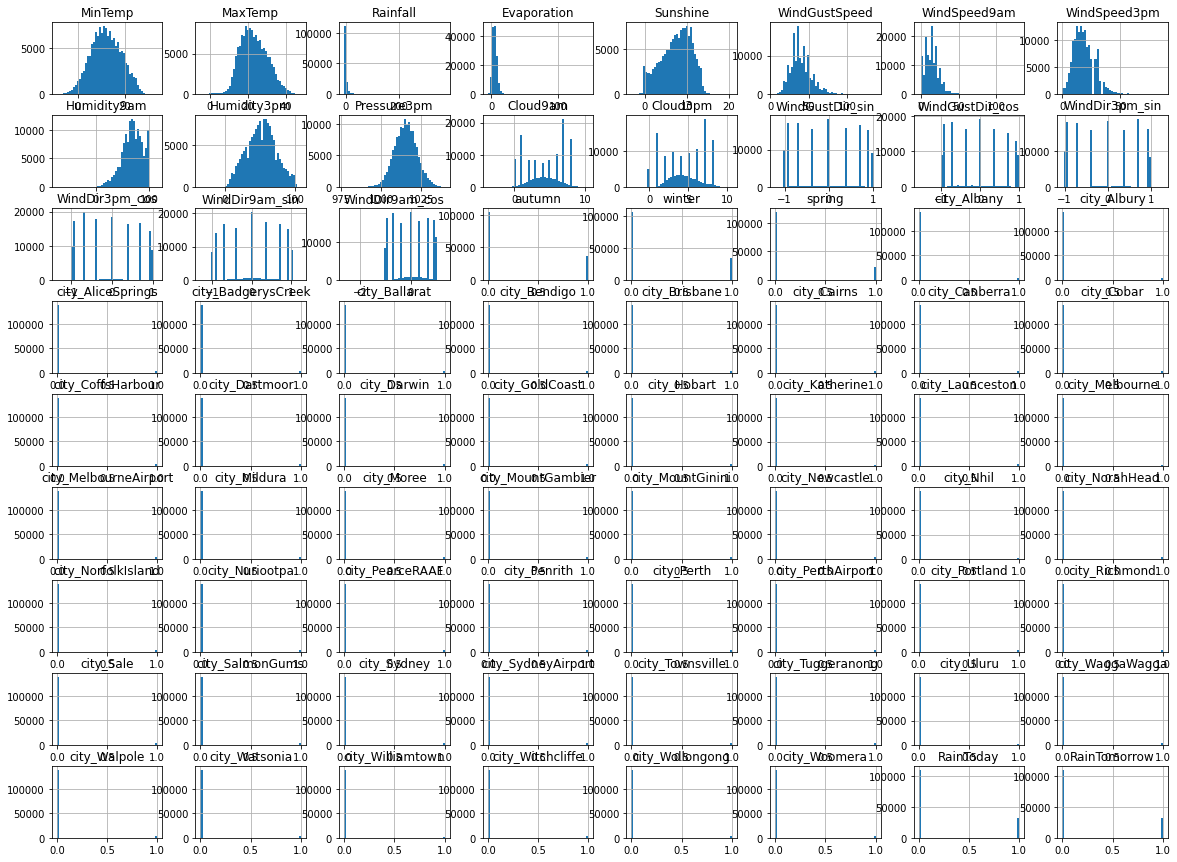

Distribución antes: 
0.0    55166
1.0    15930
Distribución despues: 
0.0    54820
1.0    43786


In [ ]:
# Preparacion data set
#                                       Execution time: +20 m Imputación
# Histogramas previo ajuste
df_eng.hist(bins=50, figsize=(20,15))
plt.show()

# Imputación MICE
MiceImputed = df_eng.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(df_eng)

# Eliminación de Outliers
#Q1 = MiceImputed.quantile(0.25)
#Q3 = MiceImputed.quantile(0.75)
#IQR = Q3 - Q1
#MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]

# Distribuciones Resultantes, post ajuste
MiceImputed.hist(bins=50, figsize=(20,15))
plt.show()

# Previo a evaluación de los modelos
# Salida
y = MiceImputed['RainTomorrow']
# Entrada
X = MiceImputed.drop(['RainTomorrow'], axis=  1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Balanceo del set
os_us = SMOTETomek(ratio=0.8)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

print("Distribución antes: ")
print(y_train.value_counts().to_string())
print("Distribución despues: ")
print(pd.DataFrame(data = y_train_res).value_counts().to_string())


In [ ]:
pipes, cv_scores, test_scores = supreme_pipe(X_train_res, y_train_res, X_test, y_test)

A continuación, se presentan los resultados obtenidos al utilizar los datos con este tratamiento:

**Scores CV set de entrenamiento**

In [ ]:
# cv_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.818 &  0.816 &       0.698 &         0.905 &         0.827 \\
Recall    &     0.777 &  0.767 &       0.782 &         0.867 &         0.779 \\
Precision &     0.806 &  0.809 &       0.628 &         0.917 &         0.819 \\
F1        &     0.791 &  0.787 &       0.697 &         0.884 &         0.801 \\
AUC       &     0.900 &  0.899 &       0.780 &         0.973 &         0.858 \\
\bottomrule
\end{tabular}


**Scores set evaluación**

In [ ]:
# test_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.828 &  0.830 &       0.650 &         0.875 &         0.813 \\
Recall    &     0.759 &  0.751 &       0.725 &         0.653 &         0.617 \\
Precision &     0.592 &  0.596 &       0.361 &         0.756 &         0.579 \\
F1        &     0.665 &  0.665 &       0.482 &         0.701 &         0.598 \\
AUC       &     0.804 &  0.802 &       0.677 &         0.796 &         0.744 \\
\bottomrule
\end{tabular}


In [ ]:
# matrices confusas
# pipe_conf_matrix(pipes, X_test, y_test)

**Resumen:**

Con la imputación de los datos faltantes y el correspondiente balanceo, se obtiene para los modelos más significativos un *ROC* de:

* Logistic Regression: 80.3 %

* LDA:                 80.2 %

* Random Forest:       79.0 %

En forma general, se obtuvieron mejoras en los *scores* de cada modelo abordado. Sigue siendo evidente un porcentaje de *overfitting* en algunos de ellos, el más notorio se da para Random Forest, para el cuál el *ROC* es de **0.97** en el entramiento y luego disminuye a **0.79** en las pruebas.

# Variables Codificadas

En este set de datos aplican las transformaciones explicadas en la sección **Tratamiento de variables**.   


Además, se experimenta con el balanceo del conjunto de entrenamiento mediante sub-sampleo de los registros de la clase mayoritaria. A diferencia de los entrenamientos anteriores, se reduce considerablemente, en un **80%** la cantidad de datos en el set de *train*.

In [ ]:
def balanceo_subsampling(X_train, y_train):
    # dataset balance por subsampleo de la clase mayoritaria
    n_pos = y_train.sum()

    X_train_pos = X_train.loc[y_train == 1,:]
    X_train_neg = X_train.loc[y_train == 0,:]

    y_train_pos = y_train.loc[y_train == 1]
    y_train_neg = y_train.loc[y_train == 0]

    df_train_neg = pd.concat([X_train_neg, y_train_neg], axis = 1)

    df_train_neg_sample = df_train_neg.sample(n = n_pos, axis = 0)

    y_train_neg_sample = df_train_neg_sample.loc[:,'RainTomorrow']
    X_train_neg_sample = df_train_neg_sample.drop(columns='RainTomorrow')

    X_train_res = pd.concat([X_train_pos, X_train_neg_sample], axis = 0)
    y_train_res = pd.concat([y_train_pos, y_train_neg_sample], axis = 0)
    print('Proporción set balanceado:')
    print(y_train_res.value_counts())
    return X_train_res, y_train_res

In [ ]:
df_nocity = df_eng.drop(columns = df_eng.columns[df_eng.columns.str.contains('city')])

df_nocity = df_nocity.dropna(axis = 'index', how = 'any')

X = df_nocity.drop(columns = 'RainTomorrow')
y = df_nocity['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train.shape

# Balanceo del set por subsampleo de la clase mayoritaria
X_train_res, y_train_res = balanceo_subsampling(X_train, y_train)

Proporción set balanceado:
1    9919
0    9919
Name: RainTomorrow, dtype: int64


In [ ]:
pipes, cv_scores, test_scores = supreme_pipe(X_train_res, y_train_res, X_test, y_test)

**Scores CV set de entrenamiento**

In [ ]:
# cv_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.802 &  0.800 &       0.768 &         0.813 &         0.738 \\
Recall    &     0.790 &  0.783 &       0.755 &         0.820 &         0.730 \\
Precision &     0.809 &  0.811 &       0.776 &         0.813 &         0.736 \\
F1        &     0.799 &  0.797 &       0.765 &         0.817 &         0.738 \\
AUC       &     0.886 &  0.886 &       0.850 &         0.897 &         0.739 \\
\bottomrule
\end{tabular}


**Scores set evaluación**

In [ ]:
# test_scores.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Logistic &    LDA &  GaussianNB &  RandomForest &  DecisionTree \\
\midrule
Accuracy  &     0.800 &  0.804 &       0.771 &         0.804 &         0.742 \\
Recall    &     0.807 &  0.800 &       0.753 &         0.820 &         0.725 \\
Precision &     0.534 &  0.540 &       0.491 &         0.539 &         0.450 \\
F1        &     0.643 &  0.645 &       0.595 &         0.651 &         0.556 \\
AUC       &     0.803 &  0.802 &       0.765 &         0.810 &         0.736 \\
\bottomrule
\end{tabular}



* Balanceando el data set por sub sampleo de la clase mayoritaria tiene un costo en el *accuracy*.
* Vemos un gran aumento del *recall* en el set de testing en todos los modelos, pasamos de valores del orden de **65%** a **82%**.
* Random Forest se ubica como el mejor clasificador en todas las métricas.
* Ya no se observa *ovefitting*.

La figura siguiente muestra las matrices de confusión de los modelos entrenados.

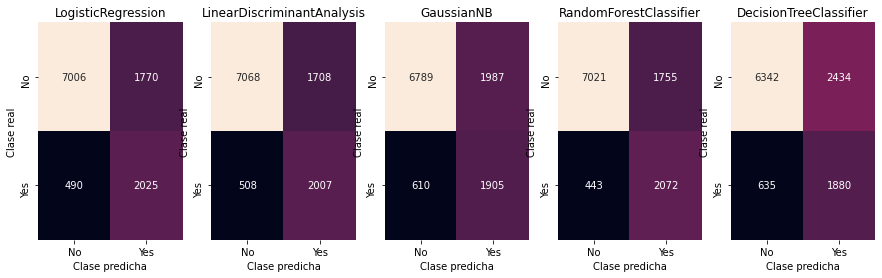

In [ ]:
# matrices confusas
pipe_conf_matrix(pipes, X_test, y_test)

* Resultaron solamente **443** falsos negativos para Random Forest.

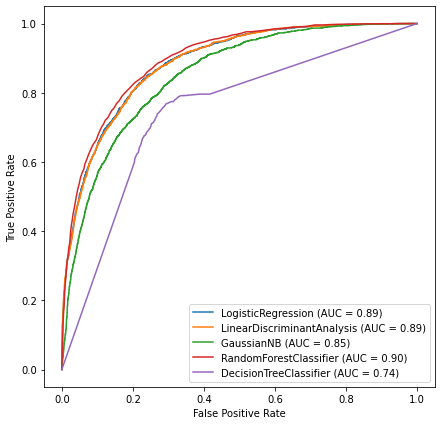

In [ ]:
plt.rcParams['figure.figsize'] = (7,7)
pipe_rocs(pipes, X_test, y_test)

* Las curvas *ROC* confirman el mejor desempeño de RF.
* *DecisionTree* tiene el peor desempeño.

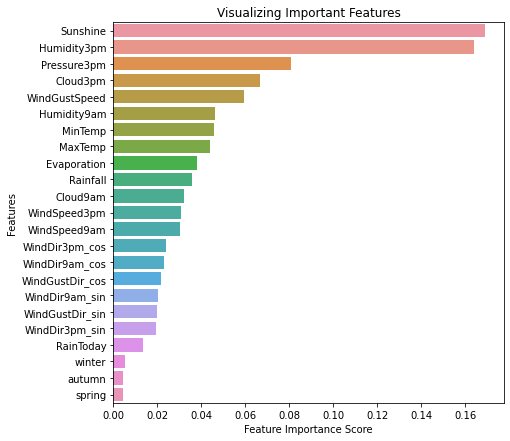

In [ ]:
# Visualizacion de la importancia de las variables en el modelo obtenido
plt.rcParams['figure.figsize'] = (7,7)
feature_imp = pd.Series(pipes[3][1].feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

* La variable más importante en este caso es *Sunshine*, es decir, el valor proporcional de exposición solar en el día. Ya que esta es una variable con un porcentaje alto de datos vacíos, este puede ser el motivo de la corrección de este problema.

### Resumen de resultados Variables Codificadas

* A pesar de la gran reducción de tamaño del set de entrenamiento, se obtuvieron resultados muy favorales. 
* Siendo el RandomForest el modelo de mejor desempeño en todas las pruebas encuanto al *AUC* con *0.81* según la tabla de test.
* En cuanto al *recall*, métrica muy importante para un clasificador más cauteloso, se observa una mejoría muy grande en cuánto al *recall* del clasificador **0.82**.
* Se soluciona el problema de *overfitting* en el RF. La hipotesis es que al ser un método iterativo, se ve afectado por la generación de datos sintéticos por parte del *Smote-Tomek*.
* Cabe destacar que la regresión logística tiene un desempeño muy bueno, teniendo la ventaja de que el modelo es interpretable.




Haciendo uso de las variables más significativas según el último RF. Creamos un modelo de regresión con ellas.

# Regresión Logística: Variables más significativas


Las variables elegidas son las 5 más importantes


*   Sunshine
*   Humidity3pm
*   Pressure3pm
*   Cloud3pm
*   WindGustSpeed



In [ ]:
fi = pipes[3][1].feature_importances_
df_fi = pd.Series(fi, index=X_train.columns)

cols_fi = df_fi.nlargest(5).index
(X_train_res, y_train_res, X_test, y_test)
# Logistic
pipe_lr5 = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000, solver = 'liblinear'))
pipe_lr5, cv_scores_lr5 = train_pipe(pipe_lr5, X_train_res[cols_fi], y_train_res, X_test[cols_fi], y_test, 'Logistic 5')

pipe_lr5, test_scores_lr5 = fit_pipe(pipe_lr5, X_train_res[cols_fi], y_train_res, X_test[cols_fi], y_test, 'Logistic 5')



**Scores CV set de entrenamiento**

In [ ]:
pd.concat([cv_scores[['Logistic','RandomForest']], cv_scores_lr5], axis = 1)

\begin{tabular}{lrrr}
\toprule
{} &  Logistic &  RandomForest &  Logistic 5 \\
\midrule
Accuracy  &     0.801 &         0.811 &       0.793 \\
Recall    &     0.791 &         0.815 &       0.789 \\
Precision &     0.807 &         0.807 &       0.796 \\
F1        &     0.799 &         0.813 &       0.792 \\
AUC       &     0.885 &         0.894 &       0.878 \\
\bottomrule
\end{tabular}


**Scores set de evaluación**

In [ ]:
pd.concat([test_scores[['Logistic','RandomForest']], test_scores_lr5], axis = 1)

\begin{tabular}{lrrr}
\toprule
{} &  Logistic &  RandomForest &  Logistic 5 \\
\midrule
Accuracy  &     0.800 &         0.805 &       0.793 \\
Recall    &     0.805 &         0.824 &       0.795 \\
Precision &     0.534 &         0.541 &       0.524 \\
F1        &     0.642 &         0.653 &       0.632 \\
AUC       &     0.802 &         0.812 &       0.794 \\
\bottomrule
\end{tabular}


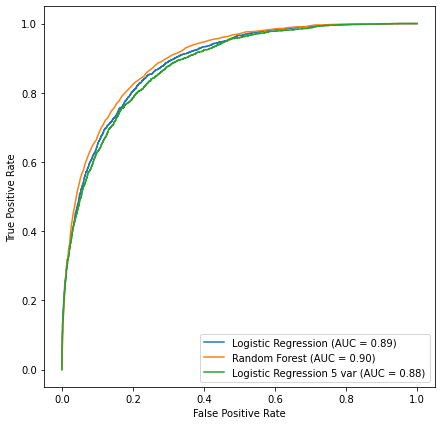

In [ ]:
plt.rcParams['figure.figsize'] = (7,7)
fig, ax = plt.subplots()
metrics.plot_roc_curve(pipes[0], X_test, y_test, ax = ax, name = 'Logistic Regression')
metrics.plot_roc_curve(pipes[3], X_test, y_test, ax = ax, name = 'Random Forest')
metrics.plot_roc_curve(pipe_lr5, X_test[cols_fi], y_test, ax = ax, name = 'Logistic Regression 5 var')
plt.show()

* Se oberva una pérdida de desempeño muy pequeña respecto de la simplificación del modelo realizada.
* Siguiendo el principio de parsimonia, se gana muchísima interpretación con este modelo.

## Interpretación

In [ ]:
coef = pipe_lr5[1].coef_.transpose()
exp_coef = np.exp(pipe_lr5[1].coef_).transpose()
df_coef = pd.DataFrame(data= coef, index = cols_fi, columns = ['Coeficiente'])
df_coef

\begin{tabular}{lr}
\toprule
{} &  Coeficiente \\
\midrule
Sunshine      &       -0.602 \\
Humidity3pm   &        1.091 \\
Pressure3pm   &       -0.557 \\
Cloud3pm      &        0.299 \\
WindGustSpeed &        0.558 \\
\bottomrule
\end{tabular}


* Podemos concluir que un aumento de '*Sunshine*' y '*Pressure3pm*' tienen un efecto negativo sobre la probabilidad de lluvia al día siguiente.
* En cambio, si '*Humidity3pm*', '*WindGustSpeed*' y '*Cloud3pm*' aumentan, también lo hace probabilidad de lluvia, en el respectivo orden de importancia.

# Conclusiones
De acuerdo al análisis realizado, y los resultados de cada uno de los modelos abordados, se decide que puede crearse un modelo con las variables disponibles a fines de predecir si lloverá al día siguiente. Las métricas obtenidas para los últimos modelos ensayados son buenas, permitiendo predecir la clase de interés con un alto índice de éxito.

El modelo *Random Forest* de la sección **Variables Condificadas** logra el mejor *ROC*, con un índice de **0.81**. Cabe resaltar que tanto el *Recall* como la *Precision*, adoptan valores de un orden similar al comparar los mejores modelos (RF, RL, LDA). Por lo tanto, a la hora de discriminar si se prefieren más errores en un falso positivo para lluvia, o, viceversa, optar por un modelo en específico no acarrearía ventajas significativas.

Además, se han podido experimentar muchas variantes de conjunto de datos, siendo la más efectiva, en este caso, la de realizar un subsampleo de la clase mayoritaria, descartando los valores nulos.

Se consiguió también construir un modelo simplificado con las cinco variables más importantes, logrando resultados comparables a los modelos completos.